In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.iolib import SimpleTable
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan, het_goldfeldquandt, het_white, het_arch
from statistics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
from scipy.stats.stats import kurtosis, skew
from scipy.stats import boxcox
from IPython.core.display import display
from patsy import dmatrices
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from arch.univariate import ARX, ARCH, GARCH
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (15,8)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['grid.linewidth'] = .5
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [2]:
df = pd.read_csv('./data/RTSI-dailyhistory-ru.csv', parse_dates=['Date'], index_col='Date', dayfirst=True)
series = df[('2009-01' < df.index) & (df.index < '2020-02')].Close
series = series.resample('1m').last()

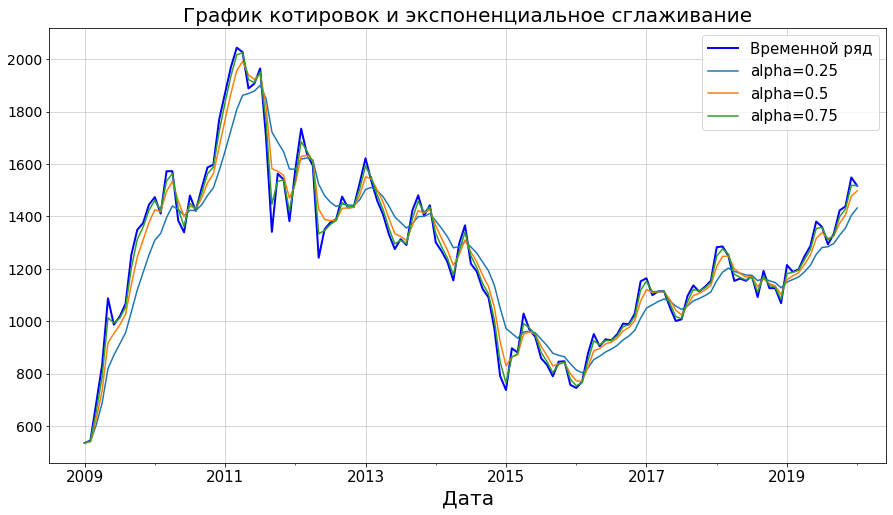

In [3]:
ax = series.plot(legend=True, color='blue', label='Временной ряд', linewidth=2)
for alpha in [.25, .5, .75]:
    series.ewm(alpha=alpha).mean().plot(ax=ax, label=f'alpha={alpha}', legend=True)
ax.set_title('График котировок и экспоненциальное сглаживание')
ax.set_xlabel('Дата');
ax.set_xlim('2008-07', '2020-06')
del ax

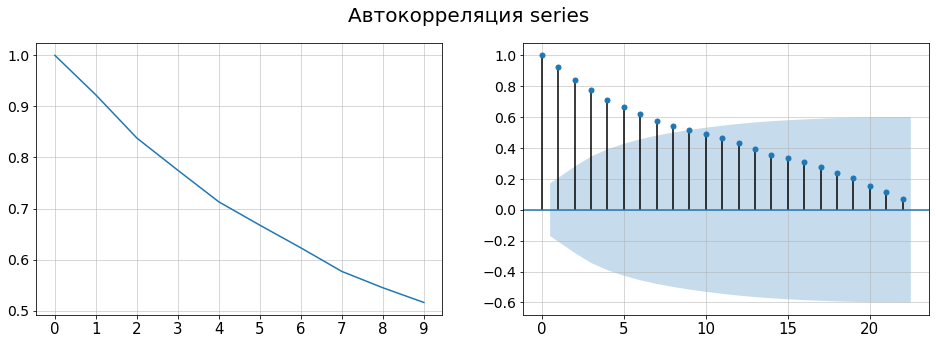

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
fig.suptitle('Автокорреляция series')

ax1.set_xticks(np.linspace(0, 10, 11))
ax1.plot(acf(series, fft=False)[:10])

plot_acf(series, ax=ax2, title='');

plt.show();
del fig, ax1, ax2

### Тест Фуллера на стационарность ряда

In [5]:
fuller_test = adfuller(series)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд нестационарен


# Составление тренда 

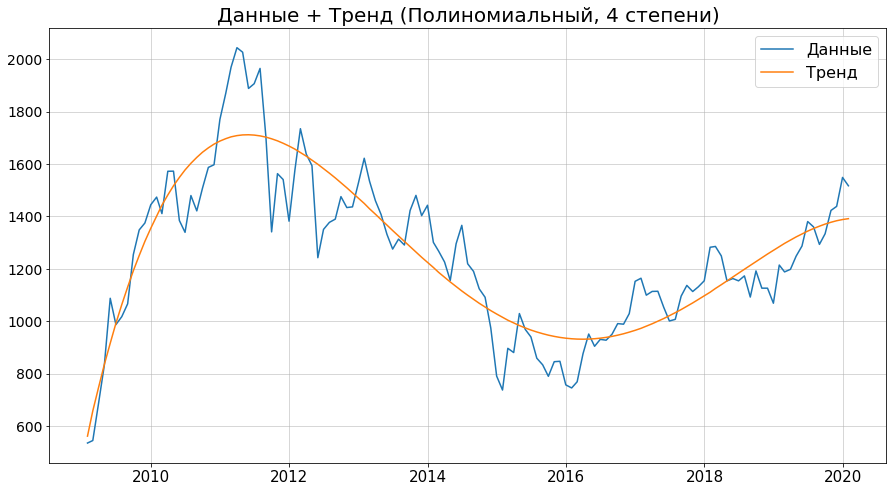

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     138.2
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           1.86e-45
Time:                        20:08:14   Log-Likelihood:                -837.17
No. Observations:                 133   AIC:                             1684.
Df Residuals:                     128   BIC:                             1699.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        561.3528     55.398     10.133      0.000     451.739     670.967
x1            99.1642      5.862     16.917      0.000      87.565     110.763
x2            -2.7296      0.182    -15.033      0.000      -3.089      -2.370
x3             0.0256      0.002     12.353      0.000       0.021       0.030
x4          -7.75e-05   7.78e-06     -9.961      0.000   -9.29e-05   -6.21e-05
==============================================================================
Omnibus:                        0.478   Durbin-Watson:                   0.527
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.247
Skew:                          -0.095   Prob(JB):                        0.884
Kurtosis:                       3.092   Cond. No.                     4.92e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
pf = PolynomialFeatures(degree=4)
xp = pf.fit_transform(np.arange(series.size)[:, np.newaxis])
fitted_model = sm.OLS(series, xp).fit()

plt.title('Данные + Тренд (Полиномиальный, 4 степени)')
plt.plot(series, label='Данные')

# Значения линии тренда
# Вместо .fittedvalues можно .predict(xp)
series_trend = fitted_model.fittedvalues
series_remains = fitted_model.resid
series_remains_exog = fitted_model.model.exog

plt.plot(series_trend, label='Тренд');
plt.legend(fontsize=16)
plt.show()
display(fitted_model.summary())
del pf, xp, fitted_model

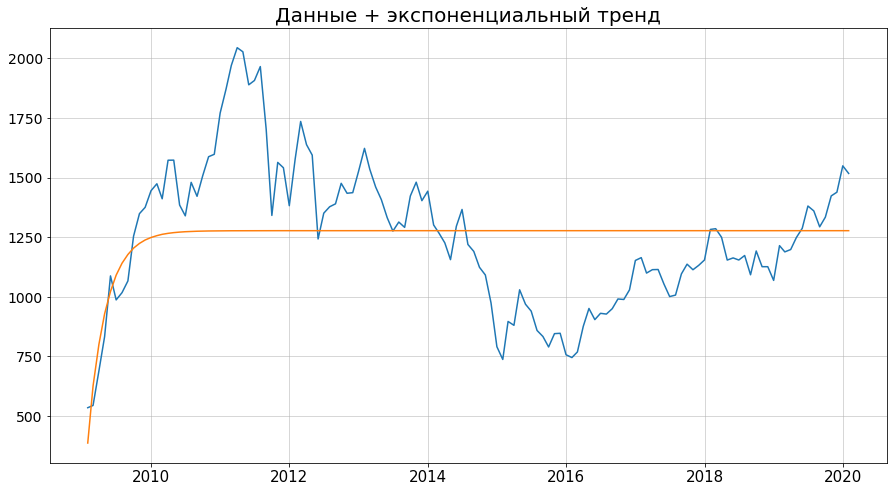

In [7]:
def func_exp(x, a, b, c):
        #c = 0
        return a * np.exp(b * x) + c

def exponential_regression(x_data, y_data):
    popt, pcov = curve_fit(func_exp, x_data, y_data, p0 = (-1, 0.01, 1))
    return func_exp(x_data, *popt)

x_data = np.arange(0, series.size) 
y_data = series
plt.title('Данные + экспоненциальный тренд')
plt.plot(series)
plt.plot(pd.Series(exponential_regression(x_data, y_data), index=series.index));

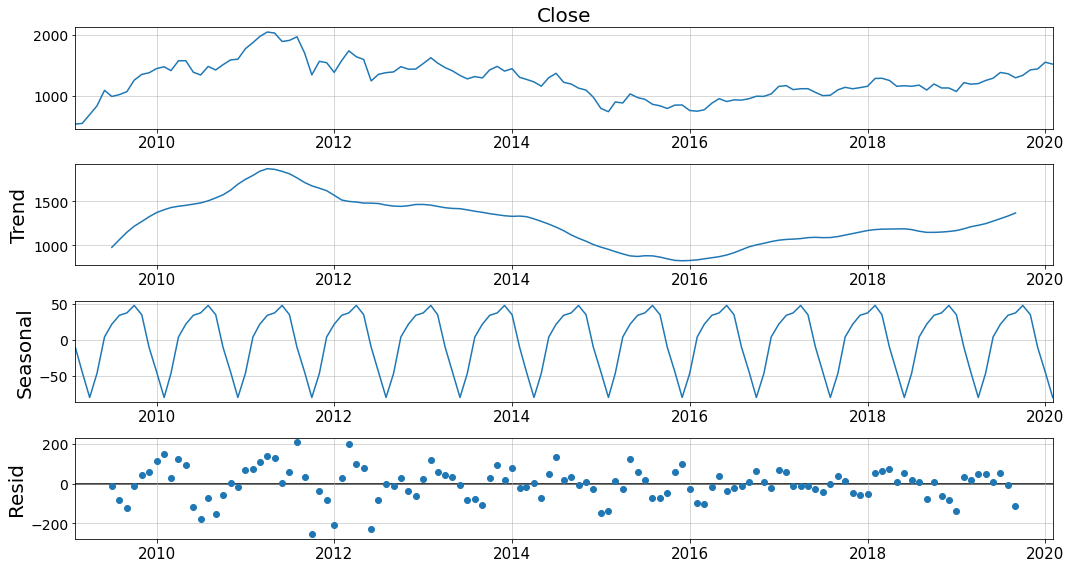

In [8]:
sm.tsa.seasonal_decompose(series.interpolate(), period=10).plot();

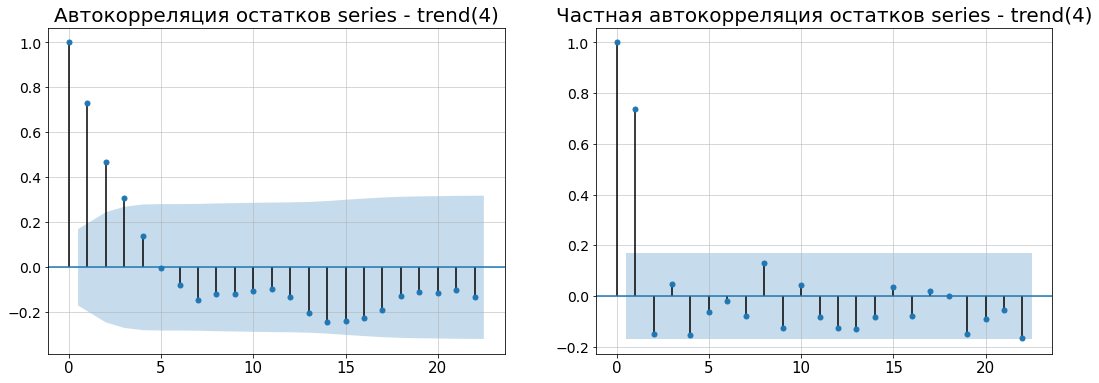

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plot_acf(series_remains, title='Автокорреляция остатков series - trend(4)', ax=ax1);
plot_pacf(series_remains, title='Частная автокорреляция остатков series - trend(4)', ax=ax2);

In [10]:
# Лучшие pdq - 4, 0, 4
model = ARIMA(series_remains, order=(4, 0, 4))
arima_by_series_remains = model.fit()
display(arima_by_series_remains.summary())

del model

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  133
Model:                     ARMA(4, 4)   Log Likelihood                -774.466
Method:                       css-mle   S.D. of innovations             79.336
Date:                Tue, 24 Mar 2020   AIC                           1568.932
Time:                        20:08:17   BIC                           1597.835
Sample:                    01-31-2009   HQIC                          1580.677
                         - 01-31-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4286      3.122      0.137      0.891      -5.691       6.548
ar.L1.y        0.2242      0.109      2.054      0.040       0.010       0.438
ar.L2.y        0.9350      0.068     13.823      0.000       0.802       1.068
ar.L3.y        0.3193      0.091      3.510      0.000       0.141       0.498
ar.L4.y       -0.6568      0.072     -9.097      0.000      -0.798      -0.515
ma.L1.y        0.5956      0.152      3.926      0.000       0.298       0.893
ma.L2.y       -0.7338      0.108     -6.787      0.000      -0.946      -0.522
ma.L3.y       -0.9442      0.111     -8.475      0.000      -1.163      -0.726
ma.L4.y        0.0824      0.148      0.558      0.577      -0.207       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8727           -0.6394j            1.0819           -0.3994
AR.2           -0.8727           +0.6394j            1.0819            0.3994
AR.3            1.1158           -0.2365j            1.1406           -0.0332
AR.4            1.1158           +0.2365j            1.1406            0.0332
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8390           -0.5442j            1.0000           -0.4084
MA.3           -0.8390           +0.5442j            1.0000            0.4084
MA.4           12.1423           -0.0000j           12.1423           -0.0000
-----------------------------------------------------------------------------
"""

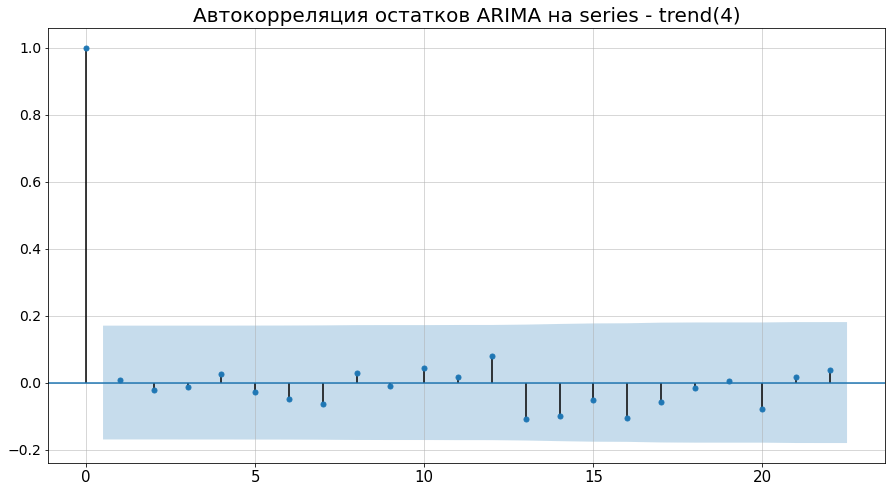

In [11]:
plot_acf(arima_by_series_remains.resid, title='Автокорреляция остатков ARIMA на series - trend(4)');

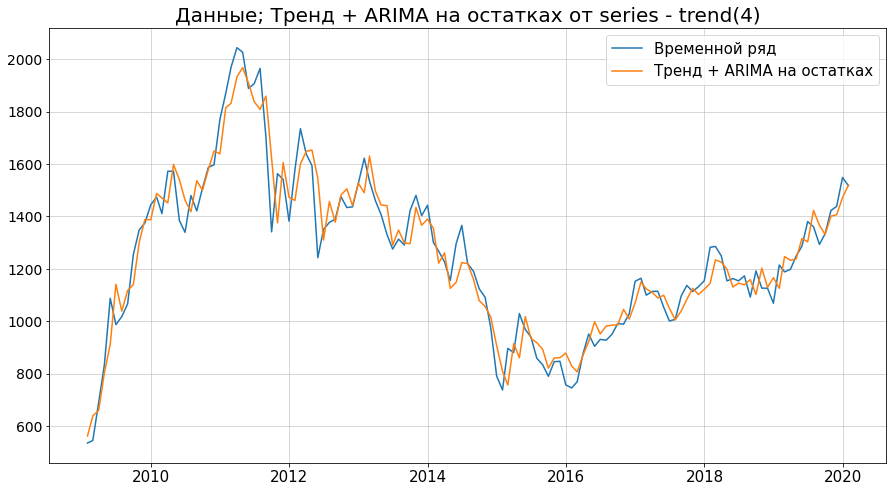

In [12]:
plt.plot(series, label='Временной ряд');
plt.plot(series_trend + arima_by_series_remains.fittedvalues, label='Тренд + ARIMA на остатках');
plt.title('Данные; Тренд + ARIMA на остатках от series - trend(4)')
plt.legend()
plt.show()

# Проверка предпосылок регрессионного анализа
#### - Нулевая средняя величина
#### - Остатки подчиняются нормальному распределению
#### - Случайный характер остатков
#### - Гомоскедастичность
#### - Отсутствие автокорреляции

## Нулевая средняя величина

In [13]:
print('Средняя величина остатков:', arima_by_series_remains.resid.mean())

Средняя величина остатков: -0.40576352477261707


## Остатки подчиняются нормальному распределению 

### На уровне значимости 0.05, нулевая гипотеза о нормальности распределения принимается

In [14]:
display(SimpleTable(
    np.array([sm.stats.stattools.jarque_bera(arima_by_series_remains.resid)]),
     ['JB', 'p-value', 'skew', 'kurtosis']
))
# p-value - вероятность неверного принятия 0-ой гипотезы о нормальности распределения

JB,p-value,skew,kurtosis
11.663434660419803,0.0029330356619095134,-0.311451321722188,4.310218392296635


### Критерии ассиметрии и эксцесса, и РС

In [15]:
kurt = kurtosis(arima_by_series_remains.resid)
n = arima_by_series_remains.resid.size
kurt_critical = 5*(24*n*(n-2)*(n-3)/(n+1)**2/(n+3)/(n+4))**.5
sk = skew(arima_by_series_remains.resid)
sk_critical = 3*(6*(n-1)/(n+1)/(n+3))**.5

if kurt < kurt_critical:
    print(f'Эксцесс {kurt:.4f} меньше критического {kurt_critical:.4f}')
else:
    print(f'Эксцесс {kurt:.4f} больше, либо равен критическому {kurt_critical:.4f}')

if sk < sk_critical:
    print(f'Ассиметрия {sk:.4f} меньше критического {sk_critical:.4f}')
else:
    print(f'Ассиметрия {sk:.4f} больше, либо равна критической {sk_critical:.4f}')
    
rem = arima_by_series_remains.resid
# Полученное значение сравнивается с табличными 
# С вероятностью ошибки-0.05 и длиной выборки-100 РС критерий должен быть в диапазон(4.31; 5.9)
rc = (rem.max() - rem.min()) / ((rem**2).sum()/len(rem)-1)**.5
print(f'РС критерий: {rc:.4f}')

Эксцесс 1.3102 меньше критического 2.0155
Ассиметрия -0.3115 меньше критического 0.6254
РС критерий: 5.9836


## Случайный характер остатков 

In [16]:
fuller_test = adfuller(arima_by_series_remains.resid)
if fuller_test[0] > fuller_test[4]['5%']:
    print('Ряд нестационарен')
else:
    print('Ряд стационарен')
del fuller_test

Ряд стационарен


## Гомоскедастичность

In [17]:
het_breuschpagan(series_remains, series_remains_exog)

(20.68638425618582,
 0.00036537936914568194,
 5.893891776290757,
 0.00021915721304981443)

In [18]:
het_goldfeldquandt(series_remains, series_remains_exog, store=True)

(0.23413467743349423,
 0.9999999729210513,
 'increasing',
 <statsmodels.stats.diagnostic.ResultsStore at 0x7ff120d5fc50>)

### F-критическое ищется по таблице F(0.01; 13, 120) = 3.255

### 5.94 > F критическое => уравнение значимое => гетероскедастичность

### Если последнее число(значимость F) < 0.05 => гетероскедастичность

In [19]:
# ТЕСТ УАЙТА на гомоскетастичность
het_white(series_remains, series_remains_exog)

(25.39451823173037,
 0.00011689961215026065,
 5.994311372305506,
 5.170011042279298e-05)

In [20]:
tmp = series_remains.to_frame()
tmp['t'] = np.arange(tmp.size)
tmp['t2'] = tmp.t ** 2
tmp['t3'] = tmp.t ** 3
tmp['t4'] = tmp.t2 ** 2
tmp['t22'] = tmp.t2.copy()
tmp['t44'] = tmp.t4.copy()
tmp['t6'] = tmp.t3 ** 2
tmp['t8'] = tmp.t4 ** 2

tmp['a'] = tmp.t3.copy()
tmp['b'] = tmp.t4.copy()
tmp['c'] = tmp.t4 * tmp.t
tmp['d'] = tmp.t4 * tmp.t
tmp['e'] = tmp.t3 ** 2
tmp['f'] = tmp.t3 * tmp.t4
tmp['remains'] = series_remains ** 2

In [21]:
f = smf.ols('remains ~ (t + t2 + t3 + t4 + t22 + t44 + t6 + t8 + a + b + c + d + e + f)', data=tmp).fit()
display(f.summary())
del tmp

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                remains   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     5.994
Date:                Tue, 24 Mar 2020   Prob (F-statistic):           5.17e-05
Time:                        20:08:18   Log-Likelihood:                -1520.6
No. Observations:                 133   AIC:                             3053.
Df Residuals:                     127   BIC:                             3071.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.8665      0.859      2.173      0.032       0.167       3.566
t             10.5313      4.841      2.176      0.031       0.953      20.110
t2           127.0697     58.292      2.180      0.031      11.721     242.418
t3            -6.0859      5.365     -1.134      0.259     -16.703       4.531
t4             0.0707      0.129      0.548      0.585      -0.185       0.326
t22          127.0737     58.293      2.180      0.031      11.721     242.426
t44            0.0707      0.129      0.548      0.585      -0.185       0.326
t6            -0.0004      0.000     -2.675      0.008      -0.001   -9.22e-05
t8         -2.102e-10   6.92e-10     -0.304      0.762   -1.58e-09    1.16e-09
a             -6.0859      5.365     -1.134      0.259     -16.703       4.531
b              0.0707      0.129      0.548      0.585      -0.185       0.326
c             -0.0007      0.004     -0.190      0.849      -0.008       0.006
d             -0.0007      0.004     -0.190      0.849      -0.008       0.006
e              0.0004      0.000      1.813      0.072   -3.22e-05       0.001
f           6.756e-08   3.44e-07      0.196      0.845   -6.14e-07    7.49e-07
==============================================================================
Omnibus:                       58.945   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.744
Skew:                           1.760   Prob(JB):                     1.68e-36
Kurtosis:                       7.164   Cond. No.                     3.19e+30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.91e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Тест парка на гомоскедастичность

### Гетероскедастичность если полученные уравнение по F-критерию значимы и значимый КФ при ln фактора

In [22]:
tmp = series.to_frame()
tmp['t'] = np.log(np.arange(1, series.size+1))
tmp['t2'] = np.log(np.arange(1, series.size+1)**2)
tmp['t3'] = np.log(np.arange(1, series.size+1)**3)
tmp['t4'] = np.log(np.arange(1, series.size+1)**4)
tmp['Close2'] = np.log(series_remains ** 2)
tmp

,Close,t,t2,t3,t4,Close2
Date,,,,,,
2009-01-31,535.04,0.000000,0.000000,0.000000,0.000000,6.540108
2009-02-28,544.58,0.693147,1.386294,2.079442,2.772589,9.458893
2009-03-31,689.63,1.098612,2.197225,3.295837,4.394449,8.166442
2009-04-30,832.87,1.386294,2.772589,4.158883,5.545177,1.477806
2009-05-31,1087.59,1.609438,3.218876,4.828314,6.437752,10.290755
...,...,...,...,...,...,...
2019-09-30,1333.91,4.859812,9.719625,14.579437,19.439250,7.216838
2019-10-31,1422.92,4.867534,9.735069,14.602603,19.470138,7.619532
2019-11-30,1438.45,4.875197,9.750395,14.625592,19.500789,8.009024


In [23]:
smf.ols('Close2 ~ t', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1103
Date:                Tue, 24 Mar 2020   Prob (F-statistic):              0.740
Time:                        20:08:18   Log-Likelihood:                -309.44
No. Observations:                 133   AIC:                             622.9
Df Residuals:                     131   BIC:                             628.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6651      0.931      9.309      0.000       6.824      10.506
t             -0.0768      0.231     -0.332      0.740      -0.534       0.381
==============================================================================
Omnibus:                       70.594   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.344
Skew:                          -1.959   Prob(JB):                     1.33e-61
Kurtosis:                       8.936   Cond. No.                         18.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
smf.ols('Close2 ~ t2', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1103
Date:                Tue, 24 Mar 2020   Prob (F-statistic):              0.740
Time:                        20:08:18   Log-Likelihood:                -309.44
No. Observations:                 133   AIC:                             622.9
Df Residuals:                     131   BIC:                             628.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6651      0.931      9.309      0.000       6.824      10.506
t2            -0.0384      0.116     -0.332      0.740      -0.267       0.190
==============================================================================
Omnibus:                       70.594   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.344
Skew:                          -1.959   Prob(JB):                     1.33e-61
Kurtosis:                       8.936   Cond. No.                         35.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
smf.ols('Close2 ~ t3', data=tmp).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Close2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1103
Date:                Tue, 24 Mar 2020   Prob (F-statistic):              0.740
Time:                        20:08:18   Log-Likelihood:                -309.44
No. Observations:                 133   AIC:                             622.9
Df Residuals:                     131   BIC:                             628.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      8.6651      0.931      9.309      0.000       6.824      10.506
t3            -0.0256      0.077     -0.332      0.740      -0.178       0.127
==============================================================================
Omnibus:                       70.594   Durbin-Watson:                   1.490
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              280.344
Skew:                          -1.959   Prob(JB):                     1.33e-61
Kurtosis:                       8.936   Cond. No.                         52.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Проверка автокорр.

### Сравниваем эту T-статистику КФ автокорр. с T-табличным

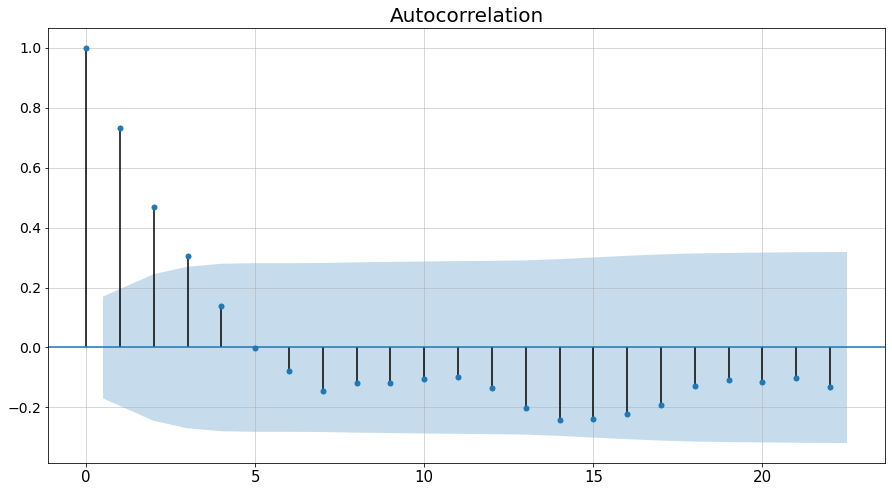

In [26]:
plot_acf(series_remains);

In [27]:
_kf = acf(series_remains, fft=False)[1]
((_kf * (series.size-2)) / (1-_kf))**.5

18.947210468161582

# Проверка остатков после (trend + Arima) 

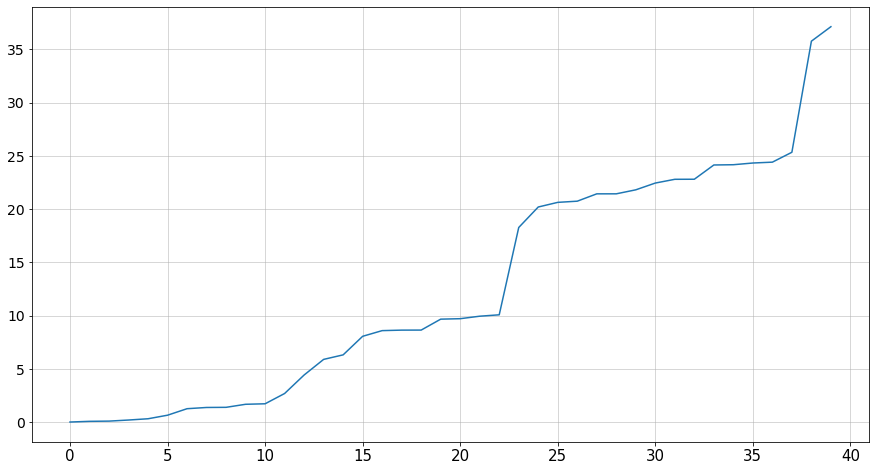

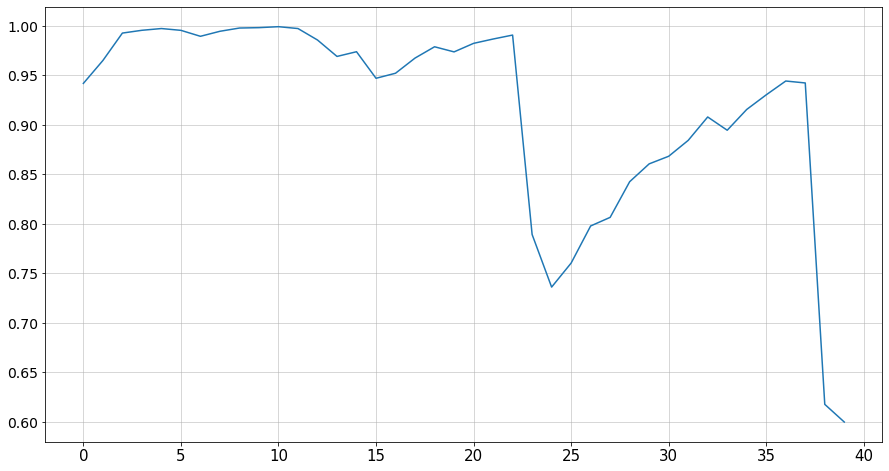

In [28]:
q_test = acf(arima_by_series_remains.resid, qstat=True, fft=False)
q_df = pd.DataFrame({'Q-stat': q_test[1], 'p-value': q_test[2]})
q_df['Q-stat'].plot()
plt.show()
q_df['p-value'].plot();
del q_test, q_df

### Остатки полученные после тренд + ARIMA по критерию бокса-льюинга являются белым шумом

# ARIMA на исходные данные 

In [29]:
arima_by_series = ARIMA(series, order=(3, 1, 3)).fit()

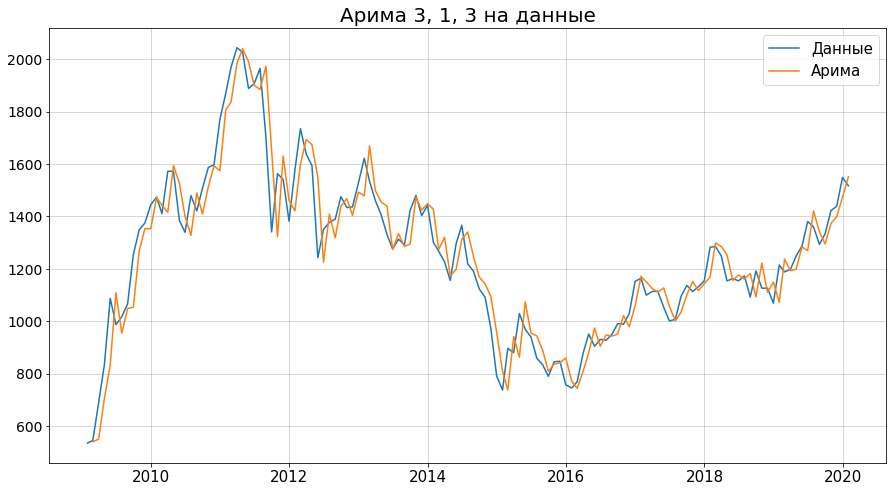

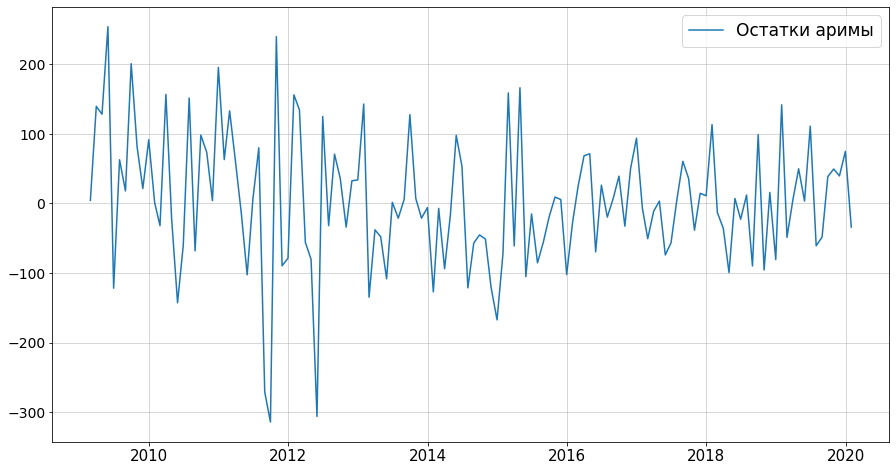

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                  132
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -788.145
Method:                       css-mle   S.D. of innovations             92.964
Date:                Tue, 24 Mar 2020   AIC                           1592.291
Time:                        20:08:20   BIC                           1615.353
Sample:                    02-28-2009   HQIC                          1601.662
                         - 01-31-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.0537      5.880      0.859      0.390      -6.472      16.579
ar.L1.D.Close    -0.5261      0.053     -9.849      0.000      -0.631      -0.421
ar.L2.D.Close     0.6020      0.054     11.211      0.000       0.497       0.707
ar.L3.D.Close     0.8497      0.057     14.976      0.000       0.739       0.961
ma.L1.D.Close     0.6764      0.041     16.521      0.000       0.596       0.757
ma.L2.D.Close    -0.6764      0.032    -20.849      0.000      -0.740      -0.613
ma.L3.D.Close    -1.0000      0.045    -22.256      0.000      -1.088      -0.912
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0225           -0.0000j            1.0225           -0.0000
AR.2           -0.8655           -0.6339j            1.0728           -0.3994
AR.3           -0.8655           +0.6339j            1.0728            0.3994
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8382           -0.5454j            1.0000           -0.4082
MA.3           -0.8382           +0.5454j            1.0000            0.4082
-----------------------------------------------------------------------------
"""

In [30]:
plt.plot(series, label='Данные')
plt.plot(series - arima_by_series.resid, label='Арима')
plt.title(f'Арима {arima_by_series.k_ar}, {arima_by_series.k_diff}, {arima_by_series.k_ma} на данные')
plt.legend(fontsize=15)
plt.show()

plt.plot(arima_by_series.resid, label='Остатки аримы')
plt.legend(fontsize=17)
plt.show();
arima_by_series.summary()

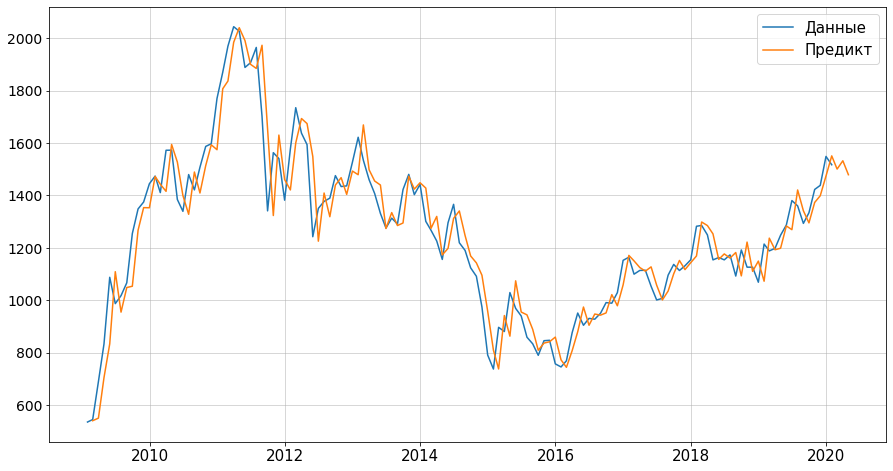

In [31]:
start = series[-1]
predicted = arima_by_series.predict('2020-02', '2020-04')
for i in range(len(predicted)):
    predicted[i] += start
    start = predicted[i]

plt.plot(series, label='Данные')
plt.plot((series - arima_by_series.resid).append(predicted), label='Предикт')
plt.legend()
plt.show();

In [32]:
series2020 = df[df.index >= '2019-12-31'].Close
predicted2020 = (series - arima_by_series.resid).append(predicted)
predicted2020 = predicted2020[predicted2020.index >= '2019-12']

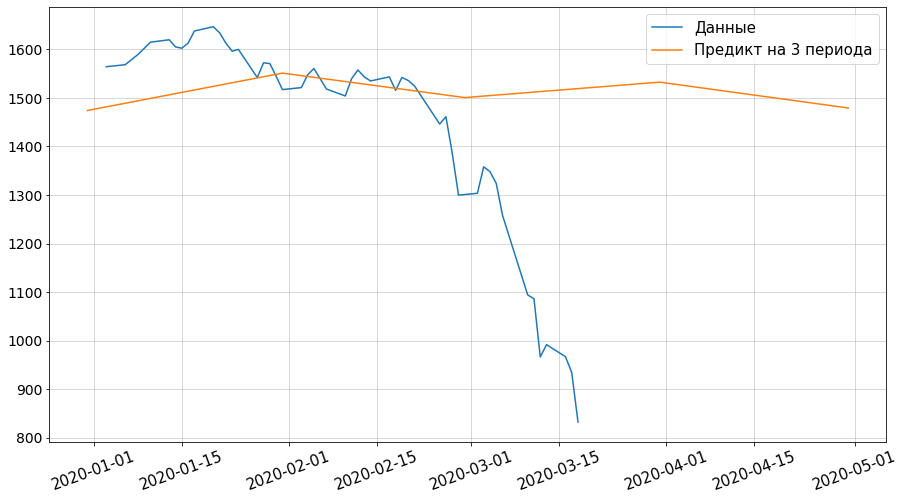

In [33]:
plt.plot(series2020, label='Данные')
plt.plot(predicted2020, label='Предикт на 3 периода')
plt.xticks(rotation=20)
plt.legend();

## Тест CHOW

In [34]:
# Оптимальный '2011-10-31' / '2016-03-31'
# chow_test_result, (split_point1, split_point2), partial_series = \
#     Model(series).cut_by_chow_test(arbitrarily=3, with_result=True)
# draw(partial_series)
# del chow_test_result, split_point1, split_point2, partial_series

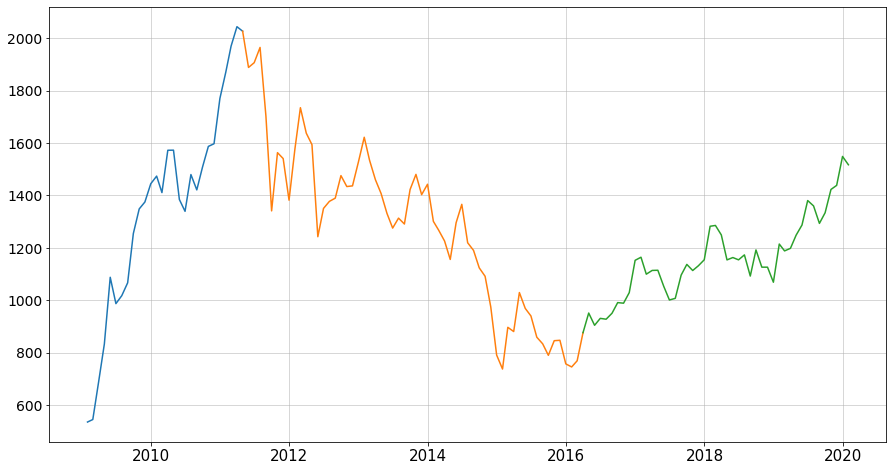

In [35]:
partial_series = PartialModel(series[:'2011-03'], series['2011-04':'2016-02'], series['2016-03':])
draw(partial_series)

### 1-ый кусок

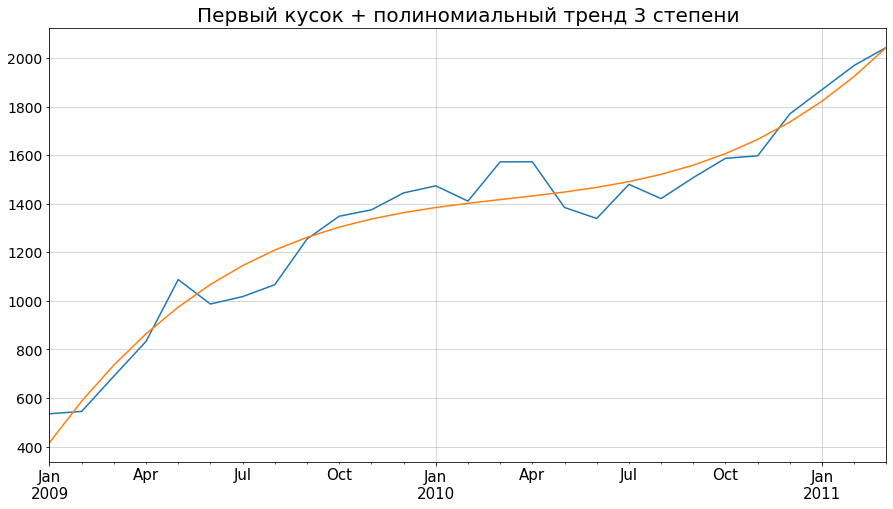

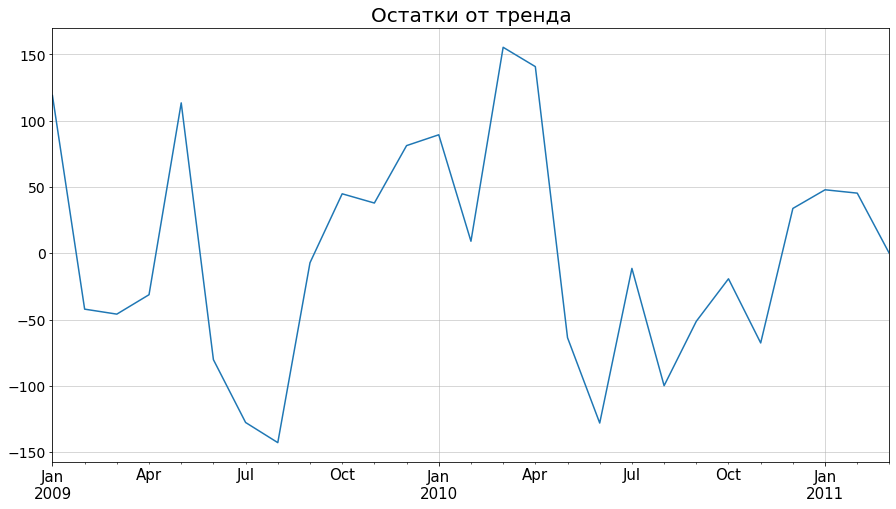

In [36]:
partial_series.p1.plot()
partial_series.p1.polynomial_trend(3).plot()
plt.title('Первый кусок + полиномиальный тренд 3 степени')
plt.xlabel('')
plt.show()

partial_series.p1.polynomial_trend(3).fitted_model.resid.plot();
plt.title('Остатки от тренда')
plt.xlabel('')
plt.show()

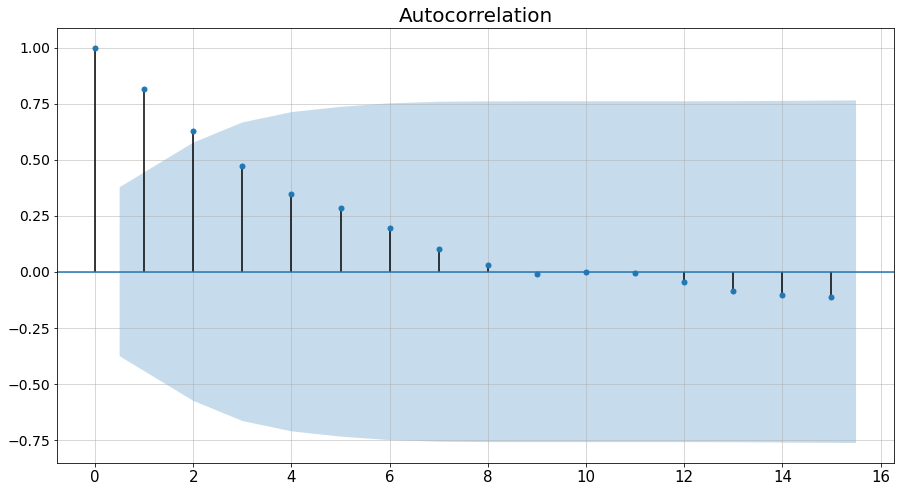

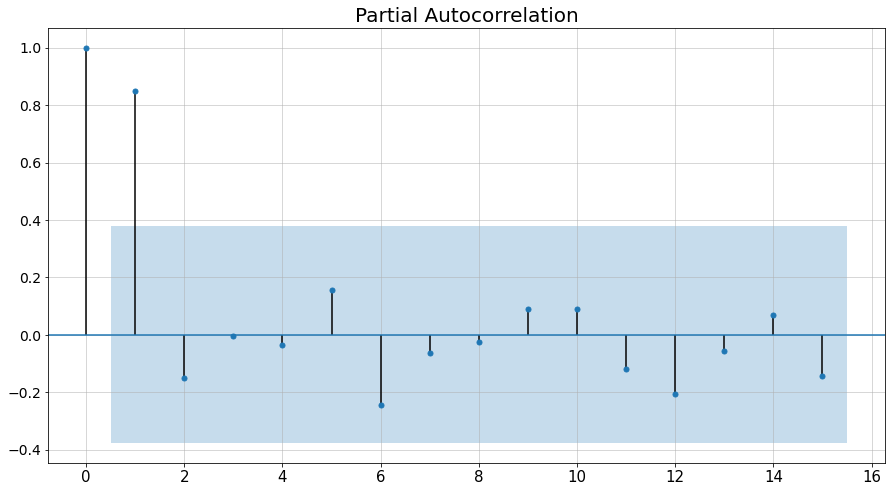

In [37]:
plot_acf(partial_series.p1)
plot_pacf(partial_series.p1);

In [38]:
garch_by_series = arch_model(series, p=7, q=7, vol='GARCH').fit();

Iteration:      1,   Func. Count:     18,   Neg. LLF: 938.4132097541119
Iteration:      2,   Func. Count:     36,   Neg. LLF: 914.7686410759334
Iteration:      3,   Func. Count:     54,   Neg. LLF: 913.488166235661
Iteration:      4,   Func. Count:     74,   Neg. LLF: 913.4266111319341
Iteration:      5,   Func. Count:     93,   Neg. LLF: 912.9414882665399
Iteration:      6,   Func. Count:    111,   Neg. LLF: 912.9120692971901
Iteration:      7,   Func. Count:    129,   Neg. LLF: 912.909940731932
Iteration:      8,   Func. Count:    147,   Neg. LLF: 912.9099103701321
Iteration:      9,   Func. Count:    165,   Neg. LLF: 912.9098945176762
Iteration:     10,   Func. Count:    183,   Neg. LLF: 912.9097956699363
Iteration:     11,   Func. Count:    201,   Neg. LLF: 912.9095837330681
Iteration:     12,   Func. Count:    219,   Neg. LLF: 912.9090376359643
Iteration:     13,   Func. Count:    237,   Neg. LLF: 912.90781846187
Iteration:     14,   Func. Count:    255,   Neg. LLF: 912.9057639023

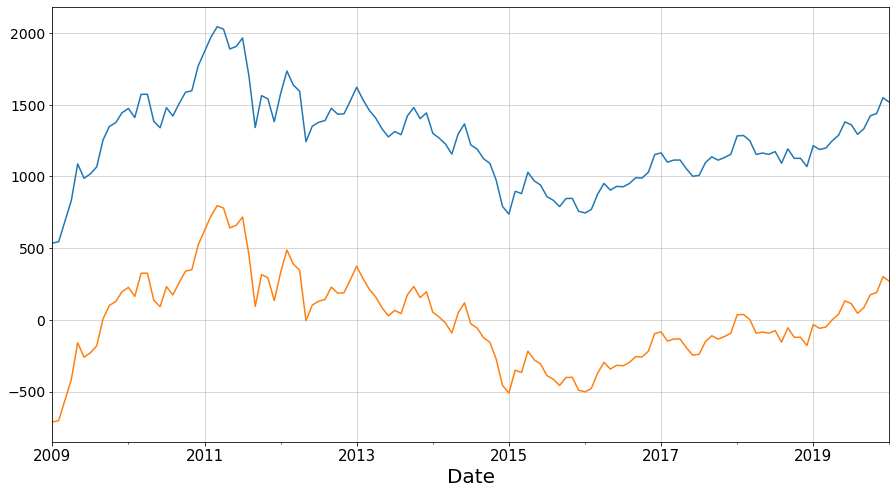

In [39]:
series.plot()
(garch_by_series.std_resid * garch_by_series.conditional_volatility).plot();

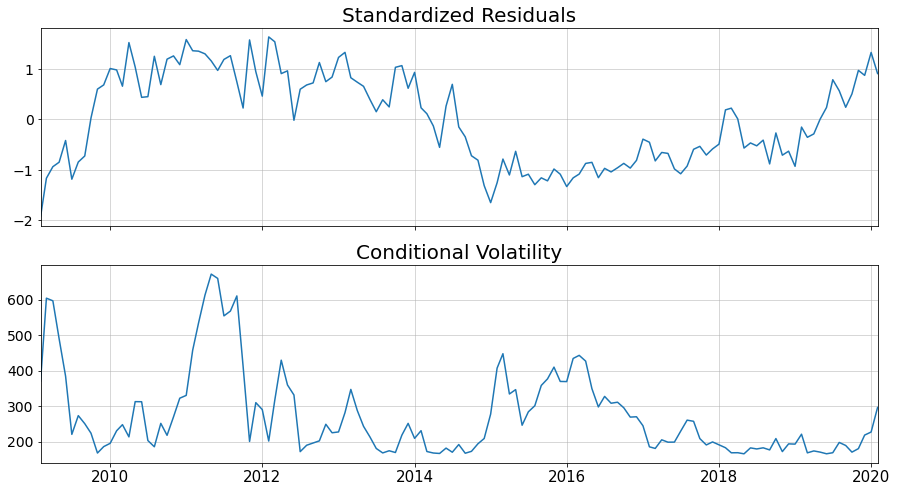

In [40]:
garch_by_series.plot();

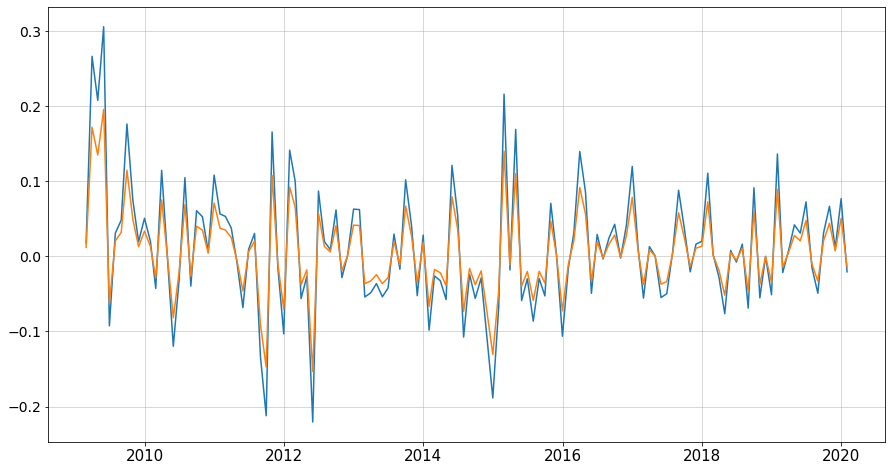

In [41]:
plt.plot(series.pct_change())
plt.plot(pd.Series(boxcox(series)[0], index=series.index).pct_change());

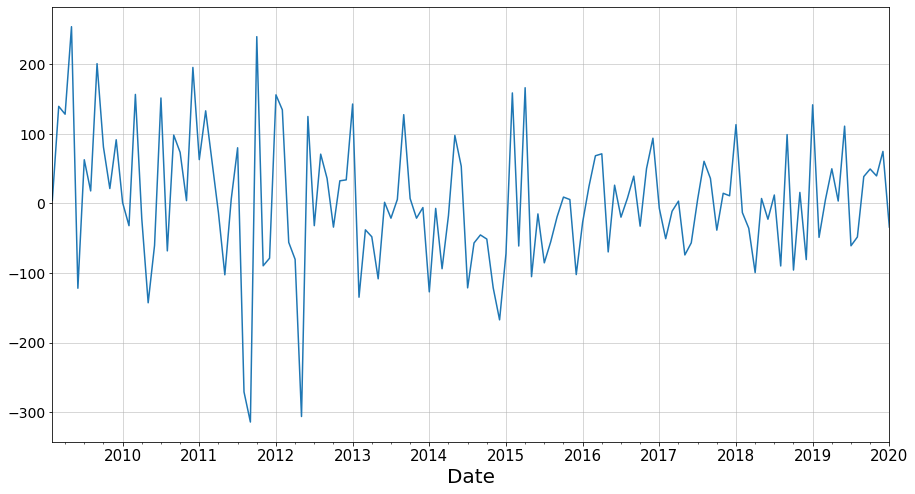

In [42]:
arima_by_series.resid.plot();

In [43]:
garch_by_arima_series = arch_model(arima_by_series.resid, vol='garch').fit();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 779.2126880383682
Iteration:      2,   Func. Count:     14,   Neg. LLF: 778.9991036376516
Iteration:      3,   Func. Count:     22,   Neg. LLF: 778.994722071689
Iteration:      4,   Func. Count:     28,   Neg. LLF: 778.9850723494999
Iteration:      5,   Func. Count:     34,   Neg. LLF: 778.9802283896211
Iteration:      6,   Func. Count:     40,   Neg. LLF: 778.9668243683934
Iteration:      7,   Func. Count:     46,   Neg. LLF: 778.946470706597
Iteration:      8,   Func. Count:     52,   Neg. LLF: 778.9270794367005
Iteration:      9,   Func. Count:     58,   Neg. LLF: 778.9202752384667
Iteration:     10,   Func. Count:     64,   Neg. LLF: 778.9194469045549
Iteration:     11,   Func. Count:     70,   Neg. LLF: 778.9194121928051
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 778.9194115258313
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations: 11


In [44]:
garch_by_arima_series.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -778.919
Distribution:                  Normal   AIC:                           1565.84
Method:            Maximum Likelihood   BIC:                           1577.37
                                        No. Observations:                  132
Date:                Tue, Mar 24 2020   Df Residuals:                      128
Time:                        20:08:23   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2444      7.182  3.403e-02      0.973 [-13.833, 14.321]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        181.4816    233.601      0.777      0.437 [-2.764e+02,6.393e+02]
alpha[1]       0.1006  8.287e-02      1.214      0.225   [-6.178e-02,  0.263]
beta[1]        0.8702  9.217e-02      9.441  3.685e-21      [  0.690,  1.051]
=============================================================================

Covariance estimator: robust
"""

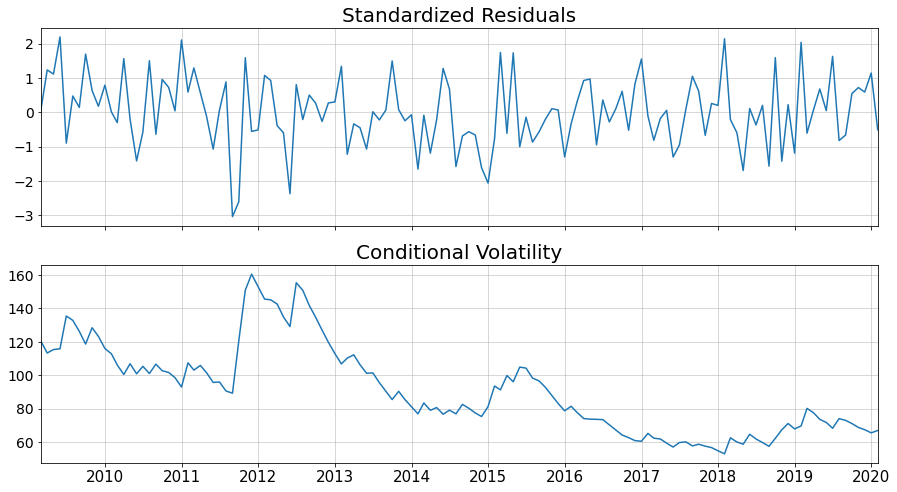

In [45]:
garch_by_arima_series.plot();

In [46]:
garch_by_arima_series.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -778.919
Distribution:                  Normal   AIC:                           1565.84
Method:            Maximum Likelihood   BIC:                           1577.37
                                        No. Observations:                  132
Date:                Tue, Mar 24 2020   Df Residuals:                      128
Time:                        20:08:23   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.2444      7.182  3.403e-02      0.973 [-13.833, 14.321]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        181.4816    233.601      0.777      0.437 [-2.764e+02,6.393e+02]
alpha[1]       0.1006  8.287e-02      1.214      0.225   [-6.178e-02,  0.263]
beta[1]        0.8702  9.217e-02      9.441  3.685e-21      [  0.690,  1.051]
=============================================================================

Covariance estimator: robust
"""

In [47]:
percent_series = series.pct_change().dropna()*100
percent_series.head()

Date
2009-02-28     1.783044
2009-03-31    26.635205
2009-04-30    20.770558
2009-05-31    30.583404
2009-06-30    -9.247051
Freq: M, Name: Close, dtype: float64

In [48]:
garch_by_percent_series = arch_model(percent_series, vol='garch', dist='Normal', p=1, q=1).fit();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 456.62260792610454
Iteration:      2,   Func. Count:     14,   Neg. LLF: 456.564639692899
Iteration:      3,   Func. Count:     21,   Neg. LLF: 456.42461898529353
Iteration:      4,   Func. Count:     27,   Neg. LLF: 456.350565837247
Iteration:      5,   Func. Count:     33,   Neg. LLF: 456.3174279665295
Iteration:      6,   Func. Count:     39,   Neg. LLF: 456.3107546170761
Iteration:      7,   Func. Count:     45,   Neg. LLF: 456.3067104216189
Iteration:      8,   Func. Count:     51,   Neg. LLF: 456.30531317388693
Iteration:      9,   Func. Count:     57,   Neg. LLF: 456.2994717967813
Iteration:     10,   Func. Count:     63,   Neg. LLF: 456.29717365031956
Iteration:     11,   Func. Count:     69,   Neg. LLF: 456.29682260562595
Iteration:     12,   Func. Count:     75,   Neg. LLF: 456.29680922754375
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 456.29680922732564
            Iterations

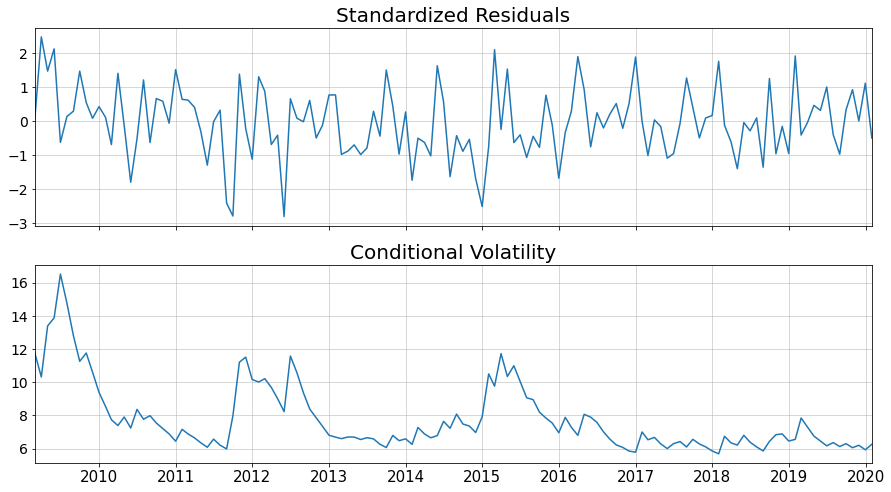

In [49]:
garch_by_percent_series.plot();

In [50]:
res = series.copy()
for i in range(1, res.size):
    res[i] = np.log(series[i]/series[i-1])
res = res[1:]

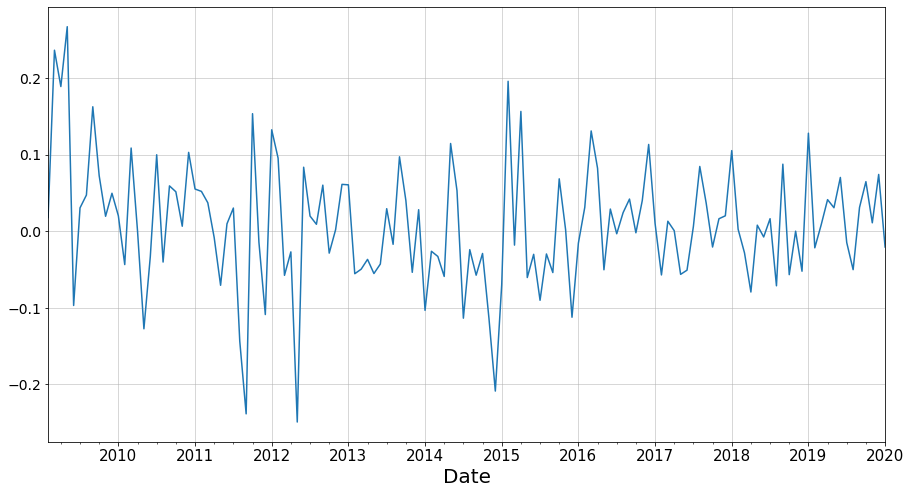

In [51]:
res.plot();

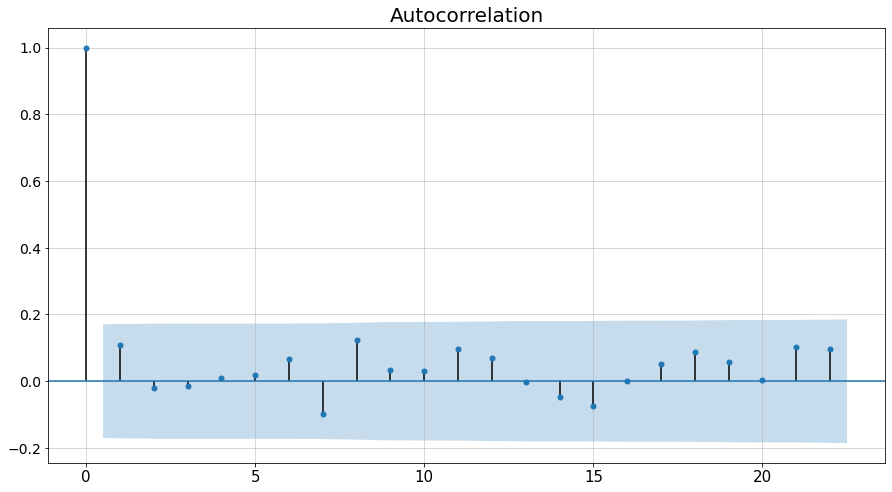

In [52]:
plot_acf(res);

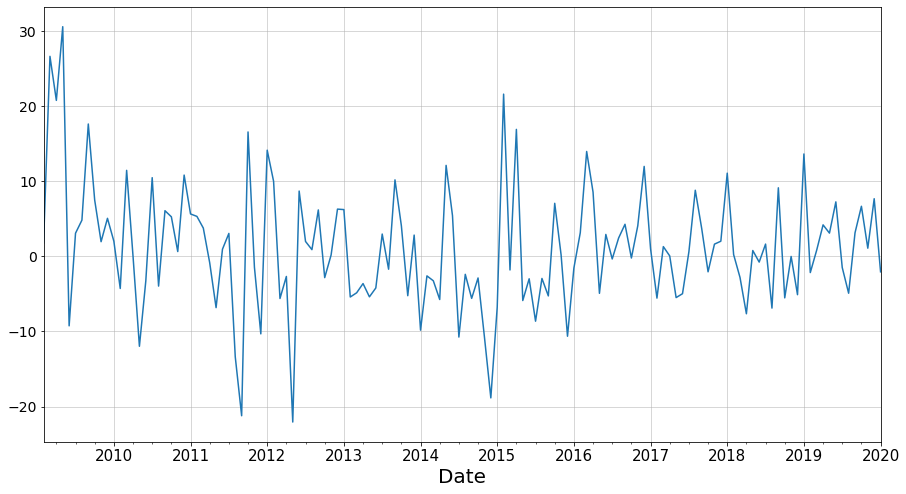

In [53]:
percent_series.plot();

In [54]:
qwe = arch_model(percent_series, vol='Garch', p=1, o=0, q=1, dist='Normal', rescale=True, mean='Zero').fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 458.11713399101006
Iteration:      2,   Func. Count:     12,   Neg. LLF: 458.08162865424504
Iteration:      3,   Func. Count:     18,   Neg. LLF: 457.83703970944373
Iteration:      4,   Func. Count:     23,   Neg. LLF: 457.7255504635468
Iteration:      5,   Func. Count:     28,   Neg. LLF: 457.59512303733896
Iteration:      6,   Func. Count:     33,   Neg. LLF: 457.5626392694038
Iteration:      7,   Func. Count:     38,   Neg. LLF: 457.5569528387002
Iteration:      8,   Func. Count:     43,   Neg. LLF: 457.5553608968347
Iteration:      9,   Func. Count:     48,   Neg. LLF: 457.54836485190214
Iteration:     10,   Func. Count:     53,   Neg. LLF: 457.54530006356396
Iteration:     11,   Func. Count:     58,   Neg. LLF: 457.54516870088287
Iteration:     12,   Func. Count:     63,   Neg. LLF: 457.545162371587
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 457.54516237146527
            Iteratio

In [55]:
qwe.forecast().variance

,h.1
Date,
2009-02-28,NaN
2009-03-31,NaN
2009-04-30,NaN
2009-05-31,NaN
2009-06-30,NaN
...,...
2019-09-30,NaN
2019-10-31,NaN
2019-11-30,NaN


### Пробуем арима + гарч

In [56]:
week_series = df[('2009-01' < df.index) & (df.index < '2020')].Close
week_series = week_series.resample('11d').last()

week_series_test = df[df.index >= '2020-01'].Close
week_series_test = week_series_test.resample('11d').last()[:3]

In [57]:
week_series_test

Date
2020-01-03    1619.73
2020-01-14    1599.82
2020-01-25    1547.19
Freq: 11D, Name: Close, dtype: float64

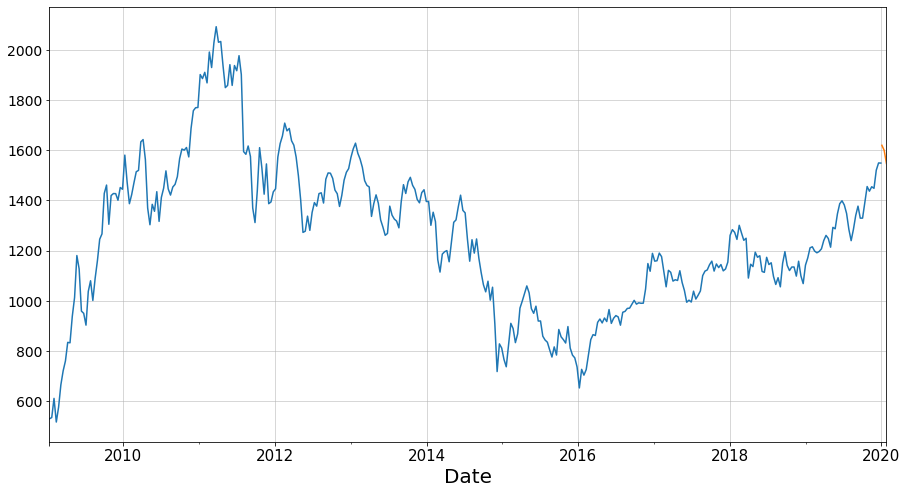

In [58]:
week_series.plot();
week_series_test.plot();

In [59]:
boxcox_series, boxcox_lambda = boxcox(week_series)
boxcox_series = pd.Series(boxcox_series, index=week_series.index).dropna()

boxcox_series_test, boxcox_lambda_test = boxcox(week_series.append(week_series_test))
boxcox_series_test = pd.Series(boxcox_series_test, index=(week_series.append(week_series_test)).index).dropna()

In [60]:
tmp = np.array([])
for i in range(1, boxcox_series.size):
    tmp = np.append(tmp, np.log(boxcox_series[i] / boxcox_series[i-1])*100)
boxcox_series_changed = pd.Series(tmp, index=boxcox_series.index[1:])

tmp = np.array([])
for i in range(1, boxcox_series_test.size):
    tmp = np.append(tmp, np.log(boxcox_series_test[i] / boxcox_series_test[i-1])*100)
boxcox_series_changed_test = pd.Series(tmp, index=boxcox_series_test.index[1:])['2020':]

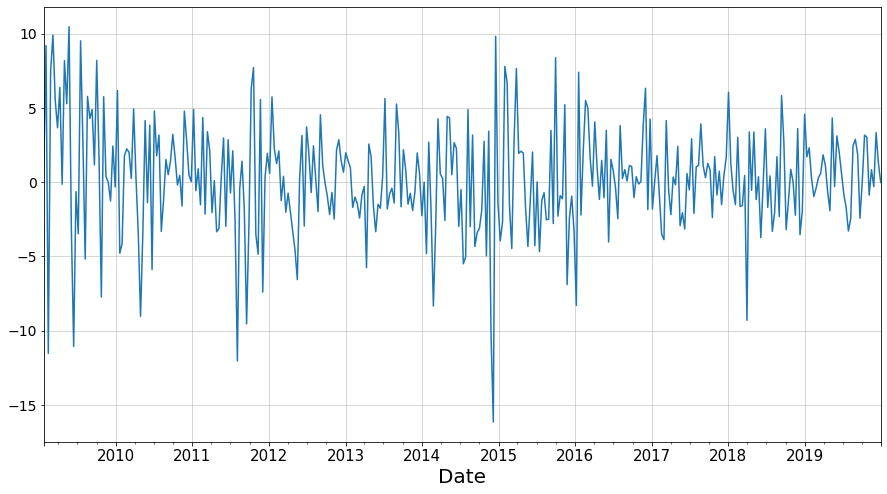

In [61]:
boxcox_series_changed.plot();

In [62]:
# Ряд стационарен
adfuller(boxcox_series_changed)

(-14.237705859198053,
 1.5568933356768793e-26,
 1,
 362,
 {'1%': -3.448544133483233,
  '5%': -2.8695574079525565,
  '10%': -2.5710411593052713},
 1829.0397009050957)

In [63]:
arima_by_boxcox_series_changed = ARIMA(boxcox_series_changed, order=(2, 0, 2)).fit()
garch_by_arima_boxcox_series_changed = \
    arch_model(arima_by_boxcox_series_changed.resid, p=1, q=1, vol='GARCH').fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 956.1536948699005
Iteration:      2,   Func. Count:     14,   Neg. LLF: 956.0504700041936
Iteration:      3,   Func. Count:     23,   Neg. LLF: 956.0277215730016
Iteration:      4,   Func. Count:     30,   Neg. LLF: 955.7828303136162
Iteration:      5,   Func. Count:     37,   Neg. LLF: 955.6077789227865
Iteration:      6,   Func. Count:     43,   Neg. LLF: 955.5463570934676
Iteration:      7,   Func. Count:     49,   Neg. LLF: 955.4600633937596
Iteration:      8,   Func. Count:     55,   Neg. LLF: 955.4443887728526
Iteration:      9,   Func. Count:     61,   Neg. LLF: 955.4421073950384
Iteration:     10,   Func. Count:     67,   Neg. LLF: 955.4419068763463
Iteration:     11,   Func. Count:     73,   Neg. LLF: 955.4418633558785
Iteration:     12,   Func. Count:     79,   Neg. LLF: 955.4418563069737
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 955.4418563071579
            Iterations: 12


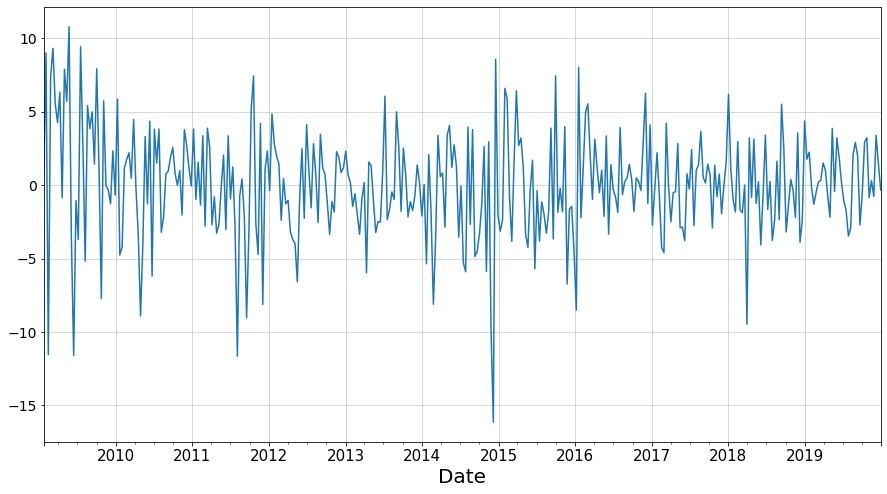

In [64]:
arima_by_boxcox_series_changed.resid.plot();

In [65]:
garch_forecast = np.random.normal(0, 1, 3) * garch_by_arima_boxcox_series_changed.forecast(horizon=3).variance.iloc[-1]**.5

In [66]:
arima_forecast = arima_by_boxcox_series_changed.forecast(steps=3)[0]

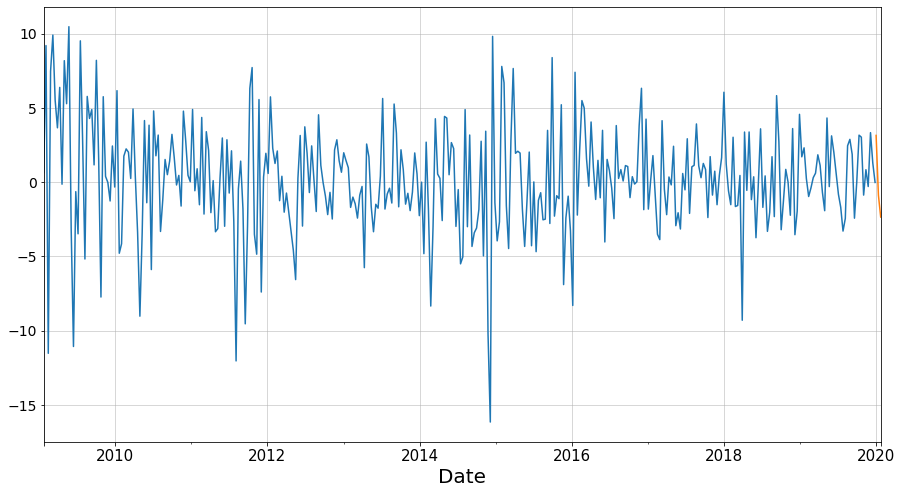

In [67]:
boxcox_series_changed.plot();
boxcox_series_changed_test.plot();

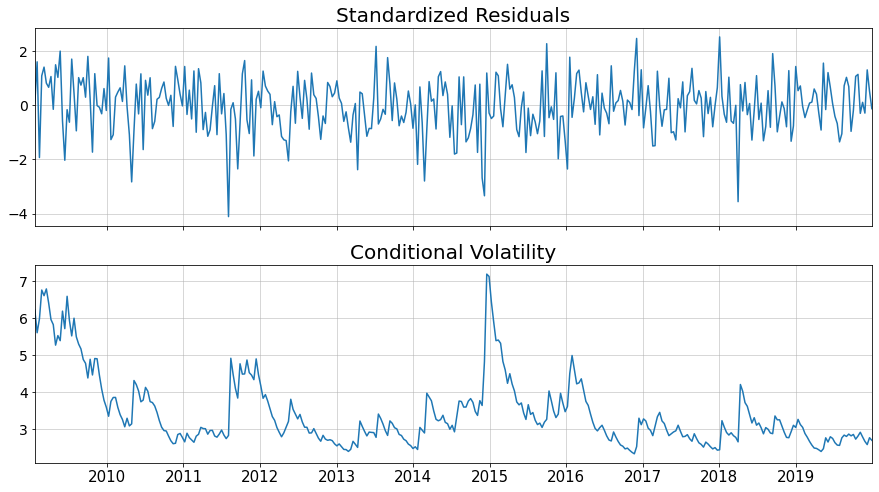

In [68]:
garch_by_arima_boxcox_series_changed.plot();

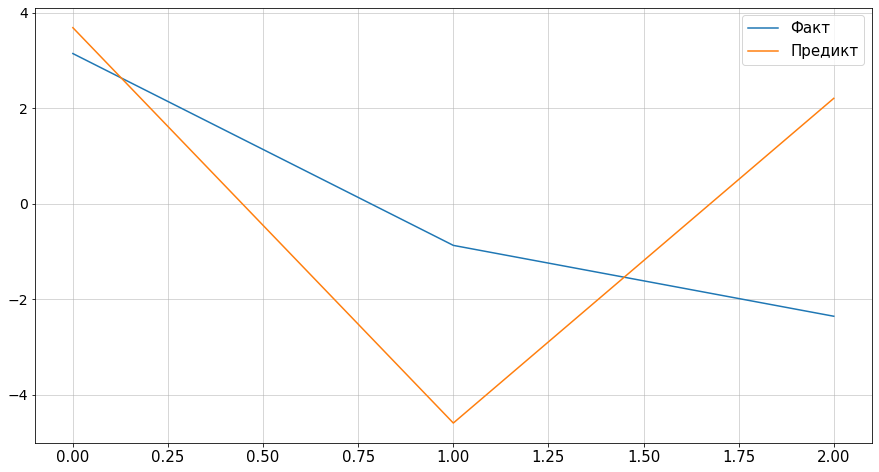

In [69]:
plt.plot(boxcox_series_changed_test.to_list(), label='Факт')
plt.plot(np.array(arima_forecast + garch_forecast), label='Предикт');
plt.legend();

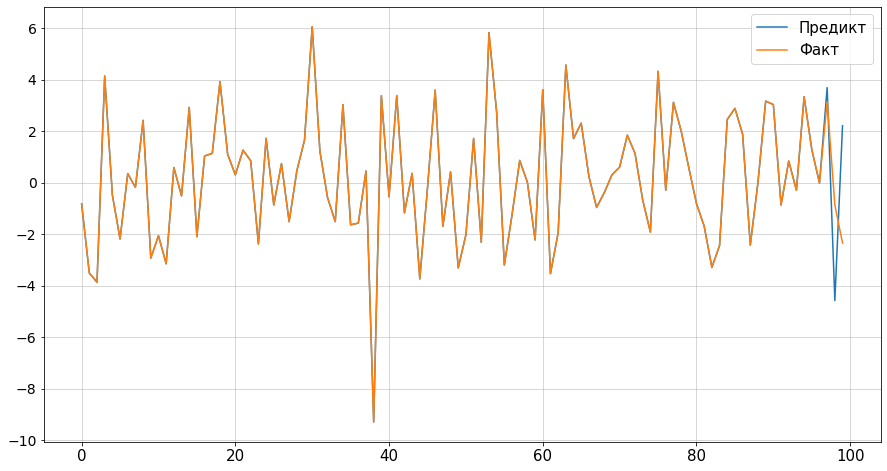

In [70]:
plt.plot(np.append(boxcox_series_changed, arima_forecast + garch_forecast)[-100:], label='Предикт');
plt.plot(np.append(boxcox_series_changed, boxcox_series_changed_test)[-100:], label='Факт');
plt.legend();

In [71]:
garch_by_arima_boxcox_series_changed.params

mu          0.004592
omega       1.000627
alpha[1]    0.123952
beta[1]     0.786655
Name: params, dtype: float64

#### Если p-value LM < 0.05, то мы отвергаем 0-ую гипотезу об отсутствии ARCH-эффектов

In [72]:
het_arch(arima_by_boxcox_series_changed.resid)

(34.902675646115966,
 0.006406840654430749,
 2.164290995057706,
 0.005087857394201729)

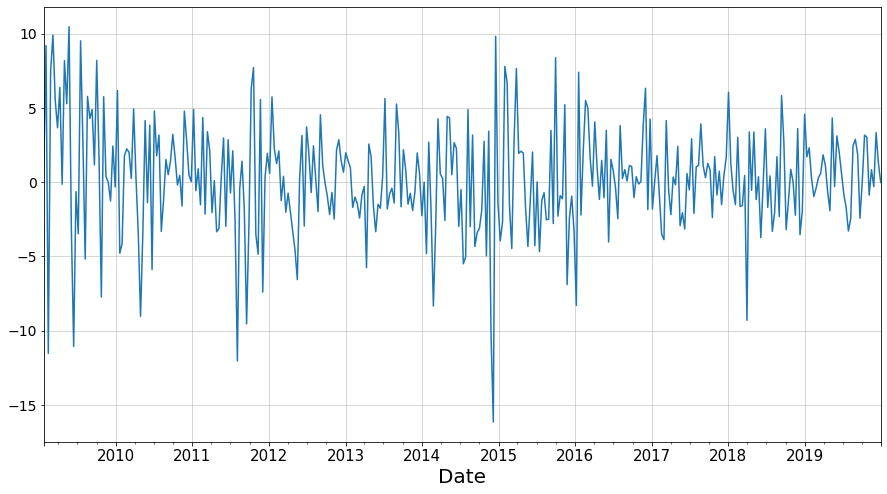

In [73]:
boxcox_series_changed.plot()

In [74]:
arima_by_boxcox_series_changed.forecast(alpha=.1)

(array([0.57501195]), array([3.60868311]), array([[-5.36074354,  6.51076744]]))

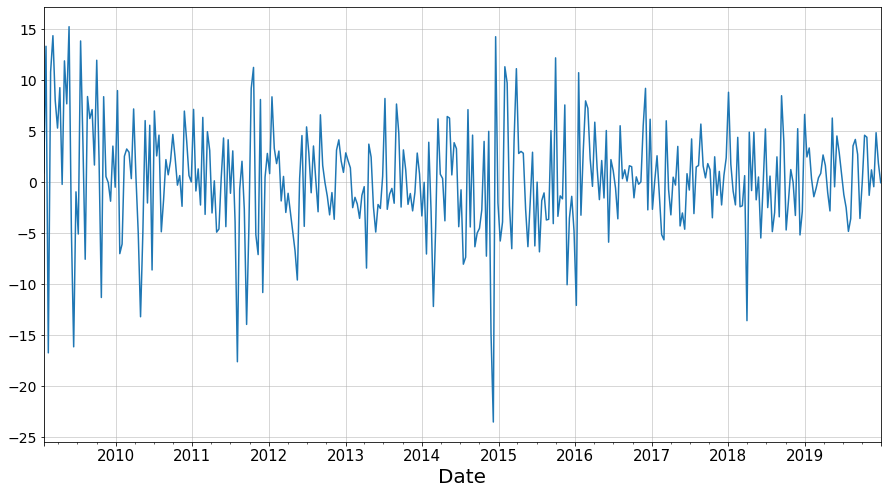

In [75]:
tmp_data = (np.log(week_series / week_series.shift(1)).dropna()*100)
tmp_data.plot();

In [76]:
qwe = ARIMA(tmp_data, order=(2,0,2)).fit()

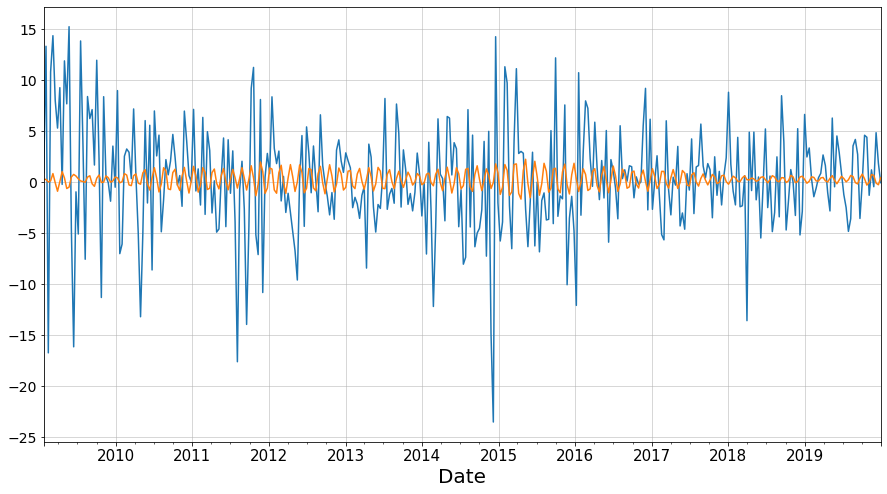

In [77]:
tmp_data.plot();
qwe.fittedvalues.plot();

Iteration:      1,   Func. Count:      6,   Neg. LLF: 1093.7764537289145
Iteration:      2,   Func. Count:     14,   Neg. LLF: 1093.6400601444102
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1093.6073903017914
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1093.3618090057353
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1093.1899900739413
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1093.09160001503
Iteration:      7,   Func. Count:     50,   Neg. LLF: 1093.0515264034748
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1093.0509315952106
Iteration:      9,   Func. Count:     62,   Neg. LLF: 1093.050842954623
Iteration:     10,   Func. Count:     68,   Neg. LLF: 1093.050841445777
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1093.0508414455967
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10


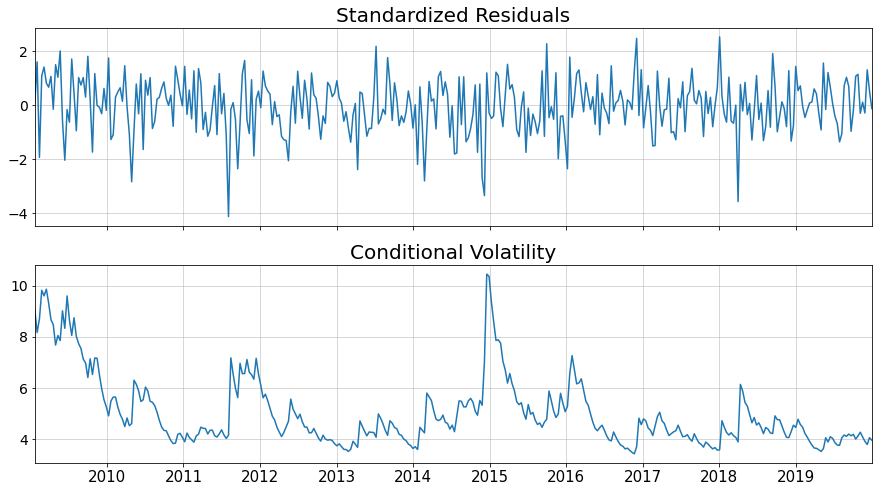

In [78]:
_ = arch_model(qwe.resid, vol='GARCH', p=1, q=1).fit()
_.plot();

# Глава

In [305]:
ar_by_week_series = ARX(series, lags=(1))
ar_by_week_series_fitted = ar_by_week_series.fit()
display(ar_by_week_series_fitted.summary())

argarch_by_week_series = ar_by_week_series
argarch_by_week_series.volatility = GARCH(p=1, q=1)
argarch_by_week_series_fitted = argarch_by_week_series.fit()
argarch_by_week_series_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     AR - Constant Variance Model Results                     
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.894
Mean Model:                        AR   Adj. R-squared:                  0.893
Vol Model:          Constant Variance   Log-Likelihood:               -790.488
Distribution:                  Normal   AIC:                           1586.98
Method:            Maximum Likelihood   BIC:                           1595.62
                                        No. Observations:                  132
Date:                Tue, Mar 24 2020   Df Residuals:                      129
Time:                        21:29:08   Df Model:                            3
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         97.4703     38.441      2.536  1.123e-02 [ 22.126,1.728e+02]
Close[1]       0.9280  3.235e-02     28.689 5.247e-181   [  0.865,  0.991]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
sigma2      9313.4771   1434.256      6.494  8.381e-11 [6.502e+03,1.212e+04]
============================================================================

Covariance estimator: White's Heteroskedasticity Consistent Estimator
"""

Iteration:      1,   Func. Count:      7,   Neg. LLF: 781.038788516242
Iteration:      2,   Func. Count:     19,   Neg. LLF: 780.8456849037924
Iteration:      3,   Func. Count:     28,   Neg. LLF: 780.7035396847298
Iteration:      4,   Func. Count:     36,   Neg. LLF: 780.69736734847
Iteration:      5,   Func. Count:     43,   Neg. LLF: 780.6820440730153
Iteration:      6,   Func. Count:     50,   Neg. LLF: 780.6818883428789
Iteration:      7,   Func. Count:     57,   Neg. LLF: 780.6818051067587
Iteration:      8,   Func. Count:     64,   Neg. LLF: 780.6812821195421
Iteration:      9,   Func. Count:     71,   Neg. LLF: 780.6784816823388
Iteration:     10,   Func. Count:     78,   Neg. LLF: 780.665993069831
Iteration:     11,   Func. Count:     85,   Neg. LLF: 780.6475365233549
Iteration:     12,   Func. Count:     92,   Neg. LLF: 780.646502396061
Iteration:     13,   Func. Count:     99,   Neg. LLF: 780.6462906001642
Iteration:     14,   Func. Count:    106,   Neg. LLF: 780.64628911848

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.894
Mean Model:                        AR   Adj. R-squared:                  0.893
Vol Model:                      GARCH   Log-Likelihood:               -780.621
Distribution:                  Normal   AIC:                           1571.24
Method:            Maximum Likelihood   BIC:                           1585.66
                                        No. Observations:                  132
Date:                Tue, Mar 24 2020   Df Residuals:                      127
Time:                        21:29:08   Df Model:                            5
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         88.8196     39.638      2.241  2.504e-02 [ 11.130,1.665e+02]
Close[1]       0.9316  3.498e-02     26.630 3.046e-156   [  0.863,  1.000]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        248.9071    272.513      0.913      0.361 [-2.852e+02,7.830e+02]
alpha[1]       0.1139  6.473e-02      1.760  7.841e-02   [-1.295e-02,  0.241]
beta[1]        0.8525  7.555e-02     11.285  1.555e-29      [  0.704,  1.001]
=============================================================================

Covariance estimator: robust
"""

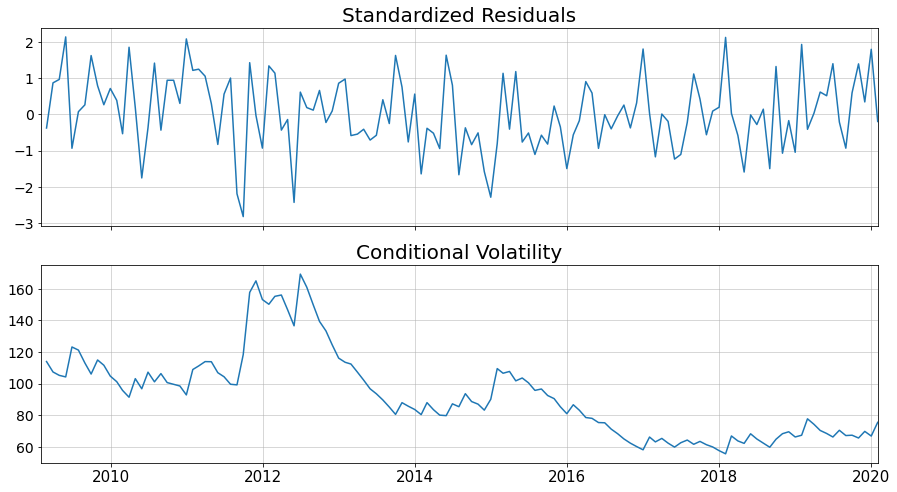

In [306]:
argarch_by_week_series_fitted.plot();

In [323]:
q = argarch_by_week_series_fitted.forecast(horizon=3, method='simulation', simulations=1_000).simulations.values

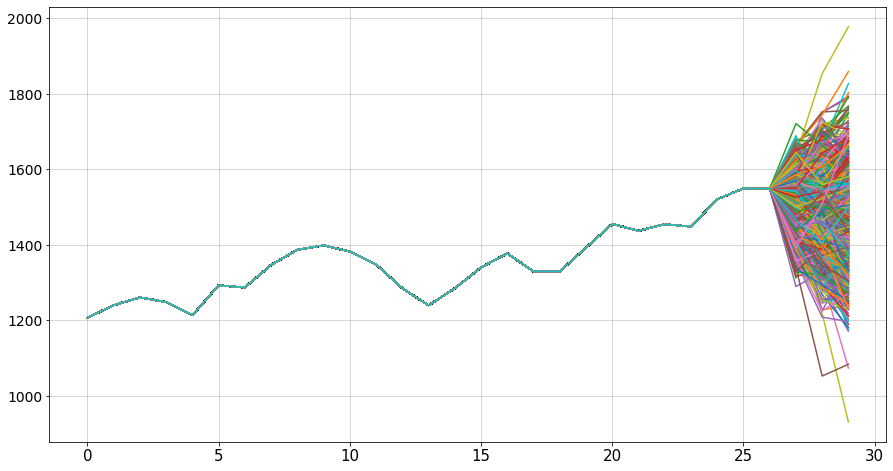

In [324]:
_ = []
for i in q[-1]:
    _.extend(i)
    plt.plot(
        range(len(week_series) + len(i))[:30],
        np.append(week_series.to_list(), _)[-30:]
    )
    _.clear()